# Uncertainty as a function of training epoch
Looking at both DER and DE models.

In [22]:
from scripts import train, models, analysis, io
import torch
import matplotlib.pyplot as plt
import numpy as np

First initialize the model.

In [23]:
noise_level = 'medium'
if noise_level == 'low':
    noise = 1
if noise_level == 'medium':
    noise = 5
if noise_level == 'high':
    noise = 10
model_name = 'SDER_noise_'+noise_level
DER_type = 'SDER'
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)
DEVICE = get_best_device()
model, _ = models.model_setup_DER(DER_type, DEVICE)

In [24]:
def load_model_checkpoint(model, model_name, epoch, device, path='../models'):
    """
    Load PyTorch model checkpoint from a .pt file.

    :param path: Location to load the model from
    :param DER_type: Type of your model
    :param epoch: Epoch to load
    :param device: Device to load the model onto ('cuda' or 'cpu')
    :param model: PyTorch model to load the checkpoint into
    :return: Loaded model
    """
    file_name = f"{path}/{model_name}_epoch_{epoch}.pt"
    
    checkpoint = torch.load(file_name, map_location=device)
    return checkpoint

def load_loss_DER(checkpoint):
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    # Extract additional information
    loaded_epoch = checkpoint.get('epoch', None)
    train_loss = checkpoint.get('train_loss', None)
    valid_loss = checkpoint.get('valid_loss', None)
    mse_valid_loss = checkpoint.get('valid_mse', None)
    return loaded_epoch, train_loss, valid_loss, mse_valid_loss


def ep_al_checkpoint_DER(checkpoint):    
    # Handle the case where extra information is present in the state_dict
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    # Extract additional information
    loaded_epoch = checkpoint.get('epoch', None)
    med_u_ep_validation = checkpoint.get('med_u_ep_validation', None)
    med_u_al_validation = checkpoint.get('med_u_al_validation', None)

    return model, loaded_epoch, med_u_ep_validation, med_u_al_validation

def ep_al_checkpoint_DE(checkpoint):    
    # Handle the case where extra information is present in the state_dict
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    # Extract additional information
    loaded_epoch = checkpoint.get('epoch', None)
    mean_validation = checkpoint.get('valid_mean', None)
    sigma_validation = checkpoint.get('valid_sigma', None)

    return model, loaded_epoch, mean_validation, sigma_validation

In [25]:
chk = load_model_checkpoint(model, model_name, 1, DEVICE)
loadmodel, epoch_model, ep_model, al_model = ep_al_checkpoint_DER(chk)

In [26]:
print(loadmodel, epoch_model, ep_model, al_model)

Sequential(
  (0): Model(
    (model): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (1): SDERLayer()
) 1 49.689323 172.62592


In [28]:
ep_high = []
al_high = []
ep_medium = []
al_medium = []
ep_low = []
al_low = []

train_loss_high = []
valid_loss_high = []
mse_valid_loss_high = []
train_loss_medium = []
valid_loss_medium = []
mse_valid_loss_medium = []
train_loss_low = []
valid_loss_low = []
mse_valid_loss_low = []

n_epochs = 100
for e in range(n_epochs):
    chk = load_model_checkpoint(model,'SDER_noise_high', e, DEVICE)
    _, _, epistemic_h, aleatoric_h = ep_al_checkpoint_DER(chk)
    ep_high.append(epistemic_h)
    al_high.append(aleatoric_h)
    # also get losses
    _, train_loss, valid_loss, mse_valid_loss = load_loss_DER(chk)
    train_loss_high.append(train_loss)
    valid_loss_high.append(valid_loss)
    mse_valid_loss_high.append(mse_valid_loss)
    
    chk = load_model_checkpoint(model, 'SDER_noise_medium', e, DEVICE)
    _, _, epistemic_m, aleatoric_m = ep_al_checkpoint_DER(chk)
    ep_medium.append(epistemic_m)
    al_medium.append(aleatoric_m)
    _, train_loss, valid_loss, mse_valid_loss = load_loss_DER(chk)
    train_loss_medium.append(train_loss)
    valid_loss_medium.append(valid_loss)
    mse_valid_loss_medium.append(mse_valid_loss)
    
    chk = load_model_checkpoint(model, 'SDER_noise_low', e, DEVICE)
    _, _, epistemic_l, aleatoric_l = ep_al_checkpoint_DER(chk)
    ep_low.append(epistemic_l)
    al_low.append(aleatoric_l)
    _, train_loss, valid_loss, mse_valid_loss = load_loss_DER(chk)
    train_loss_low.append(train_loss)
    valid_loss_low.append(valid_loss)
    mse_valid_loss_low.append(mse_valid_loss)

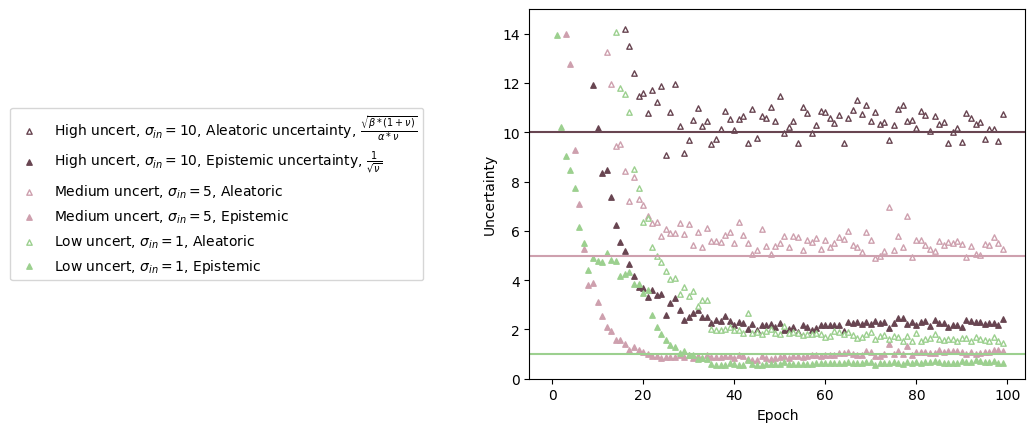

In [29]:
# overplot both
ptsize = 15
plt.clf()
plt.scatter(range(n_epochs), al_high,
            edgecolor = '#684551',
            color = 'white',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plt.scatter(range(n_epochs), ep_high,
            color = '#684551',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plt.axhline(y = 10,
            color = '#684551')

plt.scatter(range(n_epochs), al_medium,
            edgecolor = '#CEA0AE',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Aleatoric')
plt.scatter(range(n_epochs), ep_medium,
            color = '#CEA0AE',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Epistemic')
plt.axhline(y = 5,
            color = '#CEA0AE')
plt.scatter(range(n_epochs), al_low,
            edgecolor = '#9CD08F',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Aleatoric')
plt.scatter(range(n_epochs), ep_low,
            color = '#9CD08F',
            marker = '^',
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Epistemic')
plt.axhline(y = 1,
            color = '#9CD08F')
# total = sqrt(ep^2 + al^2)
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.ylim([0,15])

#plt.show()
plt.savefig('DER_ep_al_by_epoch.png')


## Lets also look at the loss plots for DER


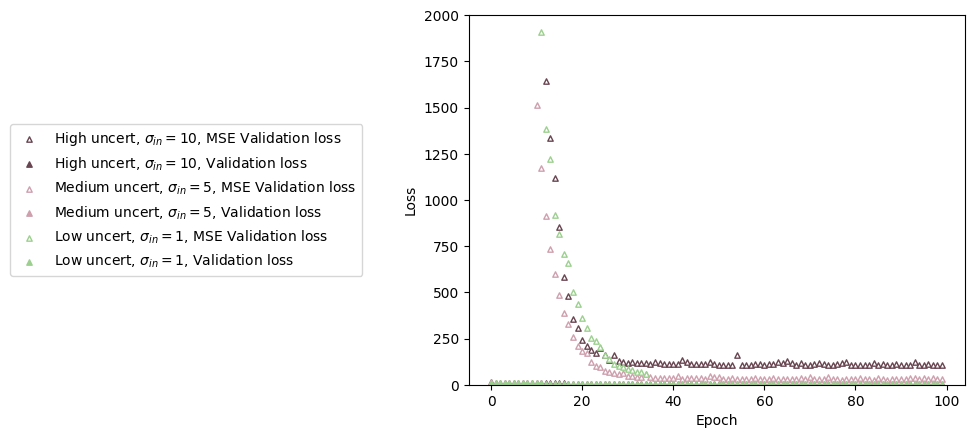

In [39]:
# overplot both
ptsize = 15
plt.clf()
plt.scatter(range(n_epochs), mse_valid_loss_high,
            edgecolor = '#684551',
            color = 'white',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, MSE Validation loss')
plt.scatter(range(n_epochs), valid_loss_high,
            color = '#684551',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Validation loss')
#plt.axhline(y = 10,
#            color = '#684551')

plt.scatter(range(n_epochs), mse_valid_loss_medium,
            edgecolor = '#CEA0AE',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, MSE Validation loss')
plt.scatter(range(n_epochs), valid_loss_medium,
            color = '#CEA0AE',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Validation loss')
#plt.axhline(y = 5,
#            color = '#CEA0AE')
plt.scatter(range(n_epochs), mse_valid_loss_low,
            edgecolor = '#9CD08F',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, MSE Validation loss')
plt.scatter(range(n_epochs), valid_loss_low,
            color = '#9CD08F',
            marker = '^',
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Validation loss')
#plt.axhline(y = 1,
#            color = '#9CD08F')
# total = sqrt(ep^2 + al^2)
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,2000])

plt.show()
#plt.savefig('DER_ep_al_by_epoch.png')


Now looking at MSE loss.

In [ ]:
# overplot both
ptsize = 15
plt.clf()
plt.scatter(range(n_epochs), train_loss_high,
            edgecolor = '#684551',
            color = 'white',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Training loss')
plt.scatter(range(n_epochs), valid_loss_high,
            color = '#684551',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Validation loss')
#plt.axhline(y = 10,
#            color = '#684551')

plt.scatter(range(n_epochs), train_loss_medium,
            edgecolor = '#CEA0AE',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Training loss')
plt.scatter(range(n_epochs), valid_loss_medium,
            color = '#CEA0AE',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Validation loss')
#plt.axhline(y = 5,
#            color = '#CEA0AE')
plt.scatter(range(n_epochs), train_loss_low,
            edgecolor = '#9CD08F',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Training loss')
plt.scatter(range(n_epochs), valid_loss_low,
            color = '#9CD08F',
            marker = '^',
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Validation loss')
#plt.axhline(y = 1,
#            color = '#9CD08F')
# total = sqrt(ep^2 + al^2)
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,20])

plt.show()
#plt.savefig('DER_ep_al_by_epoch.png')


## Now look at this for the deep ensemble models
This is a little trickier because you need to look at multiple models simultaneously.

In [9]:
nmodels = 5
nepochs = 100
DE_type = 'var_loss'
model, _, _ = models.model_setup_DE(DE_type, DEVICE)

In [10]:
low_ep = []
low_al_var = []
low_ep_std = []
low_al_var_std = []
for e in range(nepochs):
    list_mus = []
    list_sigs = []
    for n in range(nmodels):

        model_name = 'DE_noise_low_nmodel_' + str(n)
        chk = load_model_checkpoint(model, model_name, e, DEVICE)
        _, _, mu_vals, sig_vals = ep_al_checkpoint_DE(chk)
        list_mus.append(mu_vals.detach().numpy())
        list_sigs.append(sig_vals.detach().numpy()**2)
    low_ep.append(np.median(np.std(list_mus, axis = 0)))
    low_al_var.append(np.median(np.mean(list_sigs, axis = 0)))
    low_ep_std.append(np.std(np.std(list_mus, axis = 0)))
    low_al_var_std.append(np.std(np.mean(list_sigs, axis = 0)))
med_ep = []
med_al_var = []
med_ep_std = []
med_al_var_std = []
for e in range(nepochs):
    list_mus = []
    list_sigs = []
    for n in range(nmodels):
    
        model_name = 'DE_noise_medium_nmodel_' + str(n)
        chk = load_model_checkpoint(model, model_name, e, DEVICE)
        _, _, mu_vals, sig_vals = ep_al_checkpoint_DE(chk)
        list_mus.append(mu_vals.detach().numpy())
        list_sigs.append(sig_vals.detach().numpy()**2)
    med_ep.append(np.median(np.std(list_mus, axis = 0)))
    med_al_var.append(np.median(np.mean(list_sigs, axis = 0)))
    med_ep_std.append(np.std(np.std(list_mus, axis = 0)))
    med_al_var_std.append(np.std(np.mean(list_sigs, axis = 0)))

high_ep = []
high_al_var = []
high_ep_std = []
high_al_var_std = []
for e in range(nepochs):
    list_mus = []
    list_sigs = []
    for n in range(nmodels):
    
        model_name = 'DE_noise_high_nmodel_' + str(n)
        chk = load_model_checkpoint(model, model_name, e, DEVICE)
        _, _, mu_vals, sig_vals = ep_al_checkpoint_DE(chk)
        list_mus.append(mu_vals.detach().numpy())
        list_sigs.append(sig_vals.detach().numpy()**2)
    high_ep.append(np.median(np.std(list_mus, axis = 0)))
    high_al_var.append(np.median(np.mean(list_sigs, axis = 0)))
    high_ep_std.append(np.std(np.std(list_mus, axis = 0)))
    high_al_var_std.append(np.std(np.mean(list_sigs, axis = 0)))


In [11]:
print(np.shape(med_ep), np.shape(med_al_var))

(100,) (100,)


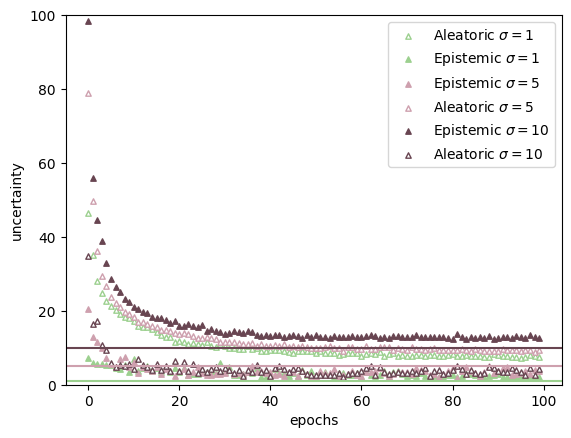

In [16]:
plt.clf()

plt.scatter(range(nepochs), np.sqrt(low_al_var), 
            edgecolor = '#9CD08F',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = 'Aleatoric $\sigma = 1$')

plt.scatter(range(nepochs), low_ep, 
            color = '#9CD08F',
            marker = '^',  
            s = ptsize,
            label = 'Epistemic $\sigma = 1$')
plt.axhline(y = 1,
            color = '#9CD08F')


plt.scatter(range(nepochs), med_ep,
            color = '#CEA0AE',
            marker = '^',  
            s = ptsize,
            label = 'Epistemic $\sigma = 5$')
plt.scatter(range(nepochs), np.sqrt(med_al_var),
            edgecolor = '#CEA0AE',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = 'Aleatoric $\sigma = 5$')
plt.axhline(y = 5,
            color = '#CEA0AE')
            

#plt.scatter(range(nepochs), high_ep, label = '$\sigma = 10$')

plt.scatter(range(nepochs), np.sqrt(high_al_var),
            color = '#684551',
            marker = '^',
            s = ptsize,
            label = 'Epistemic $\sigma = 10$')

plt.scatter(range(nepochs), high_ep,
            edgecolor = '#684551',
            color = 'white',
            marker = '^',
            s = ptsize,
            label = 'Aleatoric $\sigma = 10$')
plt.axhline(y = 10,
            color = '#684551')


plt.xlabel('epochs')
plt.ylabel('uncertainty')
plt.legend()
plt.ylim([0,100])
plt.show()

This time with errorbars.

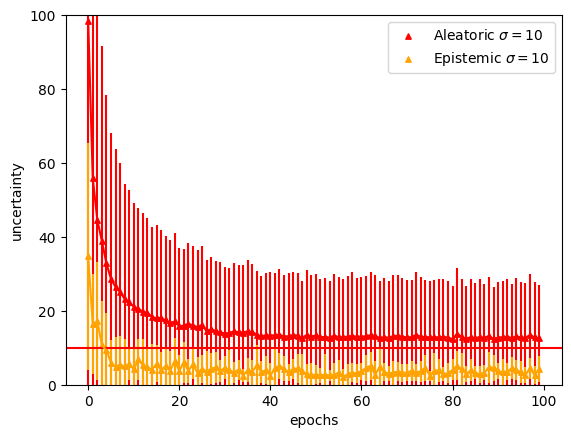

In [20]:
# first just high
plt.clf()
plt.scatter(range(nepochs), np.sqrt(high_al_var),
            color = 'red',
            marker = '^',
            s = ptsize,
            label = 'Aleatoric $\sigma = 10$')
plt.errorbar(range(nepochs), np.sqrt(high_al_var),
             yerr = np.sqrt(high_al_var_std),
             color = 'red',
             marker = None,
             ls = None)
plt.scatter(range(nepochs), high_ep,
            edgecolor = 'orange',
            color = 'orange',
            marker = '^',
            s = ptsize,
            label = 'Epistemic $\sigma = 10$')
plt.errorbar(range(nepochs), high_ep,
             yerr = high_ep_std,
             color = 'orange',
             marker = None,
             ls = None)
plt.axhline(y = 10,
            color = 'red')


plt.xlabel('epochs')
plt.ylabel('uncertainty')
plt.legend()
plt.ylim([0,100])
plt.show()